### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
np.random.seed(42)
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
np.random.seed(42)
tf.random.set_seed(42)
import pickle
import sys
import gc


Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-02 14:18:29.133063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-02 14:18:29.133203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorc

Changes from previous version: I am implementing COVID-19 classification with ProtTrans (Rostlab models) starting with the BFD

In [3]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    print(embedding_model(input_ids)[0].shape) # Residue specific embeddings
    print(embedding_model(input_ids)[1].shape) # Pooled embeddings - they did not recommend to use
    cls_embeddings = [] 
    residue_embeddings = []
    average_embeddings = []
    for seq_num in range(len(embedding)):
        cls = embedding[seq_num][0]

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        print(np.shape(residues))
        average = np.mean(residues, axis=0)

        cls_embeddings.append(cls)
        residue_embeddings.append(residues)
        average_embeddings.append(average)

    return np.asarray(cls_embeddings), np.asarray(average_embeddings), residue_embeddings

In [4]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [5]:
cls_embeddings, average_embeddings, residue_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

(2, 9)
(2, 9, 1024)
(2, 1024)
(7, 1024)
(5, 1024)


In [6]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [7]:
tf.__version__

'2.10.0'

# Data Formatting

In [8]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
5,QITLKESGPTLVKPTQTLTLTCKLSGFSVNTGGVGVGWIRQPPGKA...
32,QVQLVQSGAEVKKPGSSVKVSCKASGDTFNIYAINWVRQAPGQGLE...
33,QVQLVQSGAEVKKPGSSVKVSCKASGGTFNSYAITWVRQAPGQGLE...
34,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTHGMHWVRQAPGKGLE...
35,QVQLVQSGAEVKKPGSSVKVSCKASGGTFRRYAISWVRQAPGQGLE...
...,...
11862,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
11863,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
11864,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
11865,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [9]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11415:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11415


In [10]:
del head
del myfile
del dummy
gc.collect()

8

In [11]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [12]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [13]:
print(round(len(covid_sequences) * 0.9999999))
print(round(len(covid_sequences) * 0.6666666))
print(round(len(covid_sequences) * 0.3333333))

11415
7610
3805


In [15]:
covid_sequences_1 = [(" ".join(s)) for s in covid_sequences][:round(len(covid_sequences) * 0.3)]
covid_sequences_2 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.3):round(len(covid_sequences) * 0.6)]
covid_sequences_3 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.6):round(len(covid_sequences) * 0.9)]
covid_sequences_4 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.9):]

In [16]:
covid_cls_embeddings_1, covid_average_embeddings_1, covid_residue_embeddings_1 = get_embeddings(covid_sequences_1)

(122, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(124, 1024)
(117, 1024)
(125, 1024)
(129, 1024)
(121, 1024)
(126, 1024)
(124, 1024)
(121, 1024)
(119, 1024)
(116, 1024)
(126, 1024)
(119, 1024)
(118, 1024)
(122, 1024)
(121, 1024)
(127, 1024)
(115, 1024)
(118, 1024)
(124, 1024)
(125, 1024)
(124, 1024)
(122, 1024)
(118, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(127, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(118, 1024)
(127, 1024)
(118, 1024)
(129, 1024)
(117, 1024)
(129, 1024)
(117, 1024)
(124, 1024)
(125, 1024)
(127, 1024)
(121, 1024)
(127, 1024)
(127, 1024)
(125, 1024)
(121, 1024)
(121, 1024)
(126, 1024)
(128, 1024)
(123, 1024)
(120, 1024)
(131, 1024)
(117, 1024)
(124, 1024)
(127, 1024)
(117, 1024)
(128, 1024)
(128, 1024)
(124, 1024)
(126, 1024)
(123, 1024)
(130, 1024)
(119, 1024)
(127, 1024)
(125, 1024)
(120, 1024)
(120, 1024)
(121, 1024)
(124, 1024)
(124, 1024)
(123, 1024)
(128, 1024)
(127, 1024)
(120, 1024)
(120, 1024)
(117, 1024)
(119, 1024)
(128, 1024)
(120

In [17]:
with open("prot_bert_bfd_embeddings/covid_1.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_1, covid_average_embeddings_1, covid_residue_embeddings_1], f)

del covid_sequences_1
del covid_cls_embeddings_1
del covid_average_embeddings_1
del covid_residue_embeddings_1
gc.collect()

0

In [18]:
covid_cls_embeddings_2, covid_average_embeddings_2, covid_residue_embeddings_2 = get_embeddings(covid_sequences_2)

(121, 1024)
(121, 1024)
(136, 1024)
(120, 1024)
(124, 1024)
(120, 1024)
(111, 1024)
(124, 1024)
(123, 1024)
(124, 1024)
(125, 1024)
(123, 1024)
(118, 1024)
(127, 1024)
(130, 1024)
(122, 1024)
(121, 1024)
(126, 1024)
(131, 1024)
(123, 1024)
(120, 1024)
(116, 1024)
(127, 1024)
(120, 1024)
(124, 1024)
(123, 1024)
(120, 1024)
(128, 1024)
(120, 1024)
(122, 1024)
(118, 1024)
(127, 1024)
(127, 1024)
(125, 1024)
(127, 1024)
(123, 1024)
(121, 1024)
(117, 1024)
(121, 1024)
(121, 1024)
(132, 1024)
(125, 1024)
(119, 1024)
(120, 1024)
(117, 1024)
(127, 1024)
(123, 1024)
(126, 1024)
(121, 1024)
(122, 1024)
(123, 1024)
(122, 1024)
(122, 1024)
(122, 1024)
(119, 1024)
(123, 1024)
(127, 1024)
(120, 1024)
(129, 1024)
(123, 1024)
(123, 1024)
(117, 1024)
(130, 1024)
(128, 1024)
(122, 1024)
(123, 1024)
(123, 1024)
(123, 1024)
(124, 1024)
(124, 1024)
(125, 1024)
(120, 1024)
(117, 1024)
(124, 1024)
(123, 1024)
(130, 1024)
(121, 1024)
(130, 1024)
(125, 1024)
(121, 1024)
(119, 1024)
(134, 1024)
(119, 1024)
(118

In [19]:
with open("prot_bert_bfd_embeddings/covid_2.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_2, covid_average_embeddings_2, covid_residue_embeddings_2], f)

del covid_sequences_2
del covid_cls_embeddings_2
del covid_average_embeddings_2
del covid_residue_embeddings_2
gc.collect()

0

In [20]:
covid_cls_embeddings_3, covid_average_embeddings_3, covid_residue_embeddings_3 = get_embeddings(covid_sequences_3)

(122, 1024)
(116, 1024)
(124, 1024)
(115, 1024)
(128, 1024)
(122, 1024)
(119, 1024)
(123, 1024)
(128, 1024)
(118, 1024)
(125, 1024)
(119, 1024)
(122, 1024)
(122, 1024)
(125, 1024)
(128, 1024)
(127, 1024)
(117, 1024)
(120, 1024)
(119, 1024)
(128, 1024)
(118, 1024)
(129, 1024)
(127, 1024)
(128, 1024)
(121, 1024)
(117, 1024)
(122, 1024)
(124, 1024)
(120, 1024)
(123, 1024)
(123, 1024)
(123, 1024)
(120, 1024)
(127, 1024)
(128, 1024)
(122, 1024)
(125, 1024)
(128, 1024)
(127, 1024)
(124, 1024)
(123, 1024)
(124, 1024)
(123, 1024)
(130, 1024)
(126, 1024)
(121, 1024)
(124, 1024)
(120, 1024)
(123, 1024)
(121, 1024)
(124, 1024)
(117, 1024)
(125, 1024)
(129, 1024)
(122, 1024)
(120, 1024)
(120, 1024)
(124, 1024)
(122, 1024)
(126, 1024)
(118, 1024)
(125, 1024)
(127, 1024)
(129, 1024)
(129, 1024)
(130, 1024)
(120, 1024)
(121, 1024)
(127, 1024)
(123, 1024)
(127, 1024)
(120, 1024)
(121, 1024)
(123, 1024)
(133, 1024)
(124, 1024)
(118, 1024)
(130, 1024)
(123, 1024)
(126, 1024)
(120, 1024)
(120, 1024)
(126

In [21]:
with open("prot_bert_bfd_embeddings/covid_3.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_3, covid_average_embeddings_3, covid_residue_embeddings_3], f)

del covid_sequences_3
del covid_cls_embeddings_3
del covid_average_embeddings_3
del covid_residue_embeddings_3
gc.collect()

0

In [22]:
covid_cls_embeddings_4, covid_average_embeddings_4, covid_residue_embeddings_4 = get_embeddings(covid_sequences_4)

(129, 1024)
(127, 1024)
(122, 1024)
(116, 1024)
(116, 1024)
(117, 1024)
(119, 1024)
(126, 1024)
(116, 1024)
(120, 1024)
(116, 1024)
(123, 1024)
(119, 1024)
(128, 1024)
(128, 1024)
(128, 1024)
(125, 1024)
(123, 1024)
(125, 1024)
(128, 1024)
(127, 1024)
(126, 1024)
(121, 1024)
(118, 1024)
(127, 1024)
(123, 1024)
(116, 1024)
(126, 1024)
(121, 1024)
(126, 1024)
(122, 1024)
(125, 1024)
(119, 1024)
(120, 1024)
(122, 1024)
(125, 1024)
(125, 1024)
(121, 1024)
(124, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(126, 1024)
(128, 1024)
(122, 1024)
(128, 1024)
(124, 1024)
(127, 1024)
(120, 1024)
(124, 1024)
(126, 1024)
(122, 1024)
(121, 1024)
(122, 1024)
(121, 1024)
(124, 1024)
(120, 1024)
(125, 1024)
(125, 1024)
(130, 1024)
(121, 1024)
(123, 1024)
(120, 1024)
(123, 1024)
(125, 1024)
(122, 1024)
(128, 1024)
(122, 1024)
(119, 1024)
(117, 1024)
(120, 1024)
(126, 1024)
(115, 1024)
(122, 1024)
(122, 1024)
(127, 1024)
(117, 1024)
(119, 1024)
(120, 1024)
(128, 1024)
(125, 1024)
(121, 1024)
(128

In [23]:
with open("prot_bert_bfd_embeddings/covid_4.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_4, covid_average_embeddings_4, covid_residue_embeddings_4], f)

del covid_sequences_4
del covid_cls_embeddings_4
del covid_average_embeddings_4
del covid_residue_embeddings_4
gc.collect()

0

In [24]:
# covid_cls_embeddings = np.concatenate(covid_cls_embeddings_1, covid_cls_embeddings_2, covid_cls_embeddings_3, covid_cls_embeddings_4)
# covid_average_embeddings = np.concatenate(covid_average_embeddings_1, covid_average_embeddings_2, covid_average_embeddings_3, covid_average_embeddings_4)
# covid_residue_embeddings = covid_residue_embeddings_1 + covid_residue_embeddings_2 + covid_residue_embeddings_3 + covid_residue_embeddings_4

In [25]:
healthy_sequences_1 = [(" ".join(s)) for s in healthy_sequences][:round(len(healthy_sequences) * 0.3)]
healthy_sequences_2 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.3):round(len(healthy_sequences) * 0.6)]
healthy_sequences_3 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.6):round(len(healthy_sequences) * 0.9)]
healthy_sequences_4 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.9):]

In [26]:
healthy_cls_embeddings_1, healthy_average_embeddings_1, healthy_residue_embeddings_1 = get_embeddings(healthy_sequences_1)

(123, 1024)
(106, 1024)
(119, 1024)
(100, 1024)
(111, 1024)
(108, 1024)
(121, 1024)
(101, 1024)
(120, 1024)
(107, 1024)
(120, 1024)
(111, 1024)
(107, 1024)
(133, 1024)
(125, 1024)
(102, 1024)
(127, 1024)
(103, 1024)
(124, 1024)
(118, 1024)
(125, 1024)
(106, 1024)
(119, 1024)
(112, 1024)
(103, 1024)
(110, 1024)
(102, 1024)
(106, 1024)
(106, 1024)
(107, 1024)
(113, 1024)
(104, 1024)
(116, 1024)
(124, 1024)
(121, 1024)
(103, 1024)
(121, 1024)
(103, 1024)
(123, 1024)
(117, 1024)
(108, 1024)
(120, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(122, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(103, 1024)
(125, 1024)
(109, 1024)
(105, 1024)
(122, 1024)
(120, 1024)
(109, 1024)
(107, 1024)
(121, 1024)
(101, 1024)
(105, 1024)
(114, 1024)
(121, 1024)
(121, 1024)
(111, 1024)
(102, 1024)
(124, 1024)
(104, 1024)
(116, 1024)
(115, 1024)
(106, 1024)
(121, 1024)
(123, 1024)
(109, 1024)
(120, 1024)
(102, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(124, 1024)
(121, 1024)
(123

In [27]:
with open("prot_bert_bfd_embeddings/healthy_1.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_1, healthy_average_embeddings_1, healthy_residue_embeddings_1], f)

del healthy_sequences_1
del healthy_cls_embeddings_1
del healthy_average_embeddings_1
del healthy_residue_embeddings_1
gc.collect()

0

In [28]:
healthy_cls_embeddings_2, healthy_average_embeddings_2, healthy_residue_embeddings_2 = get_embeddings(healthy_sequences_2)

(115, 1024)
(126, 1024)
(125, 1024)
(127, 1024)
(125, 1024)
(118, 1024)
(121, 1024)
(124, 1024)
(104, 1024)
(127, 1024)
(120, 1024)
(127, 1024)
(115, 1024)
(128, 1024)
(104, 1024)
(119, 1024)
(124, 1024)
(127, 1024)
(105, 1024)
(118, 1024)
(124, 1024)
(117, 1024)
(116, 1024)
(106, 1024)
(106, 1024)
(124, 1024)
(121, 1024)
(120, 1024)
(118, 1024)
(124, 1024)
(121, 1024)
(121, 1024)
(122, 1024)
(106, 1024)
(123, 1024)
(117, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(109, 1024)
(118, 1024)
(127, 1024)
(125, 1024)
(122, 1024)
(116, 1024)
(121, 1024)
(100, 1024)
(113, 1024)
(125, 1024)
(118, 1024)
(124, 1024)
(104, 1024)
(109, 1024)
(128, 1024)
(125, 1024)
(120, 1024)
(118, 1024)
(104, 1024)
(122, 1024)
(105, 1024)
(110, 1024)
(107, 1024)
(101, 1024)
(121, 1024)
(124, 1024)
(103, 1024)
(118, 1024)
(121, 1024)
(121, 1024)
(128, 1024)
(103, 1024)
(107, 1024)
(104, 1024)
(126, 1024)
(107, 1024)
(123, 1024)
(124, 1024)
(103, 1024)
(111, 1024)
(126, 1024)
(111, 1024)
(111, 1024)
(119, 1024)
(124

In [29]:
with open("prot_bert_bfd_embeddings/healthy_2.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_2, healthy_average_embeddings_2, healthy_residue_embeddings_2], f)

del healthy_sequences_2
del healthy_cls_embeddings_2
del healthy_average_embeddings_2
del healthy_residue_embeddings_2
gc.collect()

0

In [30]:
healthy_cls_embeddings_3, healthy_average_embeddings_3, healthy_residue_embeddings_3 = get_embeddings(healthy_sequences_3)

(124, 1024)
(117, 1024)
(114, 1024)
(128, 1024)
(108, 1024)
(108, 1024)
(102, 1024)
(129, 1024)
(101, 1024)
(104, 1024)
(124, 1024)
(124, 1024)
(101, 1024)
(110, 1024)
(120, 1024)
(107, 1024)
(103, 1024)
(116, 1024)
(107, 1024)
(107, 1024)
(116, 1024)
(126, 1024)
(124, 1024)
(109, 1024)
(108, 1024)
(108, 1024)
(119, 1024)
(115, 1024)
(125, 1024)
(121, 1024)
(120, 1024)
(107, 1024)
(116, 1024)
(107, 1024)
(119, 1024)
(109, 1024)
(110, 1024)
(123, 1024)
(103, 1024)
(105, 1024)
(102, 1024)
(103, 1024)
(115, 1024)
(127, 1024)
(126, 1024)
(104, 1024)
(103, 1024)
(115, 1024)
(126, 1024)
(124, 1024)
(103, 1024)
(111, 1024)
(115, 1024)
(125, 1024)
(103, 1024)
(106, 1024)
(104, 1024)
(105, 1024)
(124, 1024)
(111, 1024)
(120, 1024)
(102, 1024)
(102, 1024)
(122, 1024)
(122, 1024)
(117, 1024)
(120, 1024)
(109, 1024)
(123, 1024)
(104, 1024)
(120, 1024)
(128, 1024)
(126, 1024)
(120, 1024)
(106, 1024)
(123, 1024)
(124, 1024)
(122, 1024)
(115, 1024)
(106, 1024)
(118, 1024)
(121, 1024)
(103, 1024)
(121

In [31]:
with open("prot_bert_bfd_embeddings/healthy_3.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_3, healthy_average_embeddings_3, healthy_residue_embeddings_3], f)

del healthy_sequences_3
del healthy_cls_embeddings_3
del healthy_average_embeddings_3
del healthy_residue_embeddings_3
gc.collect()

0

In [32]:
healthy_cls_embeddings_4, healthy_average_embeddings_4, healthy_residue_embeddings_4 = get_embeddings(healthy_sequences_4)

(110, 1024)
(124, 1024)
(121, 1024)
(110, 1024)
(120, 1024)
(104, 1024)
(100, 1024)
(107, 1024)
(101, 1024)
(118, 1024)
(115, 1024)
(120, 1024)
(125, 1024)
(123, 1024)
(125, 1024)
(109, 1024)
(114, 1024)
(106, 1024)
(111, 1024)
(121, 1024)
(102, 1024)
(115, 1024)
(122, 1024)
(107, 1024)
(110, 1024)
(102, 1024)
(110, 1024)
(129, 1024)
(126, 1024)
(112, 1024)
(103, 1024)
(106, 1024)
(114, 1024)
(102, 1024)
(105, 1024)
(107, 1024)
(107, 1024)
(113, 1024)
(115, 1024)
(103, 1024)
(103, 1024)
(114, 1024)
(121, 1024)
(126, 1024)
(107, 1024)
(121, 1024)
(115, 1024)
(107, 1024)
(106, 1024)
(123, 1024)
(110, 1024)
(108, 1024)
(101, 1024)
(109, 1024)
(119, 1024)
(106, 1024)
(107, 1024)
(132, 1024)
(124, 1024)
(123, 1024)
(117, 1024)
(123, 1024)
(120, 1024)
(124, 1024)
(108, 1024)
(117, 1024)
(122, 1024)
(122, 1024)
(118, 1024)
(113, 1024)
(107, 1024)
(101, 1024)
(110, 1024)
(105, 1024)
(119, 1024)
(122, 1024)
(103, 1024)
(105, 1024)
(102, 1024)
(114, 1024)
(107, 1024)
(117, 1024)
(105, 1024)
(116

In [33]:
with open("prot_bert_bfd_embeddings/healthy_4.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_4, healthy_average_embeddings_4, healthy_residue_embeddings_4], f)

del healthy_sequences_4
del healthy_cls_embeddings_4
del healthy_average_embeddings_4
del healthy_residue_embeddings_4
gc.collect()

0

# Loading

In [8]:
covid_residue_embeddings = []

In [9]:
for i in range(1, 5):
    with open("prot_bert_bfd_embeddings/covid_" + str(i) + ".pkl", "rb") as f:
        covid_temp = pickle.load(f)
        for j in covid_temp[2]:
            covid_residue_embeddings.append(j)
    f.close()

In [10]:
print(covid_residue_embeddings[0].shape)

(122, 1024)


In [11]:
healthy_residue_embeddings = []

In [12]:
for i in range(1, 5):

    with open("prot_bert_bfd_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        for j in healthy_temp[2]:
            healthy_residue_embeddings.append(j)
    f.close()

In [13]:
global_maxlen = 138 # this needs to be known a priori, from the max aa length block earlier

def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    Z = np.zeros((len(M), global_maxlen, 1024))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] = row 
    return Z

In [14]:
covid_residue_embeddings = pad_to_dense(covid_residue_embeddings)
healthy_residue_embeddings = pad_to_dense(healthy_residue_embeddings)

In [15]:
healthy_lables = [0] * 11415
covid_lables = [1] * 11415

# Model

In [16]:
X = np.concatenate(([i for i in healthy_residue_embeddings], [i for i in covid_residue_embeddings]))
y = np.concatenate((healthy_lables, covid_lables))

In [17]:
del healthy_residue_embeddings
del covid_residue_embeddings
gc.collect()

0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
del X
del y
gc.collect()

0

In [ ]:
# X_train = np.expand_dims(X_train, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)

In [19]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(138, 1024)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.summary()

model = tf.keras.models.Sequential([
  # tf.keras.layers.Conv2D(64, (6, 6), activation='relu', input_shape=(138, 1024, 1)),
  # tf.keras.layers.MaxPooling2D((2,3), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,3), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Input((138, 1024)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM((512), return_sequences=True)),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),

  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 138, 1024)        6295552   
 l)                                                              
                                                                 
 dropout_91 (Dropout)        (None, 138, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_92 (Dropout)        (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [20]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-02 14:26:52.831047: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 14:26:56.846860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:26:57.403371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:26:57.422956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:26:59.110340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:26:59.129985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:27:01.067169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

578/578 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5055

2023-01-02 14:29:21.977565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:29:22.159445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:29:22.174406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:29:22.574897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:29:22.591270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 157s 255ms/step - loss: 0.6939 - accuracy: 0.5055 - val_loss: 0.6930 - val_accuracy: 0.5032
Epoch 2/50
578/578 [==============================] - 133s 230ms/step - loss: 0.6806 - accuracy: 0.5237 - val_loss: 0.6020 - val_accuracy: 0.6462
Epoch 3/50
578/578 [==============================] - 133s 229ms/step - loss: 0.6516 - accuracy: 0.5513 - val_loss: 0.4154 - val_accuracy: 0.7976
Epoch 4/50
578/578 [==============================] - 140s 242ms/step - loss: 0.6443 - accuracy: 0.5576 - val_loss: 0.3938 - val_accuracy: 0.8112
Epoch 5/50
578/578 [==============================] - 132s 228ms/step - loss: 0.6404 - accuracy: 0.5530 - val_loss: 0.4055 - val_accuracy: 0.8131
Epoch 6/50
578/578 [==============================] - 131s 226ms/step - loss: 0.6405 - accuracy: 0.5558 - val_loss: 0.4010 - val_accuracy: 0.8024
Epoch 7/50
578/578 [==============================] - 131s 226ms/step - loss: 0.6377 - accuracy: 0.5596 - val_loss: 0.3715 - val_accura

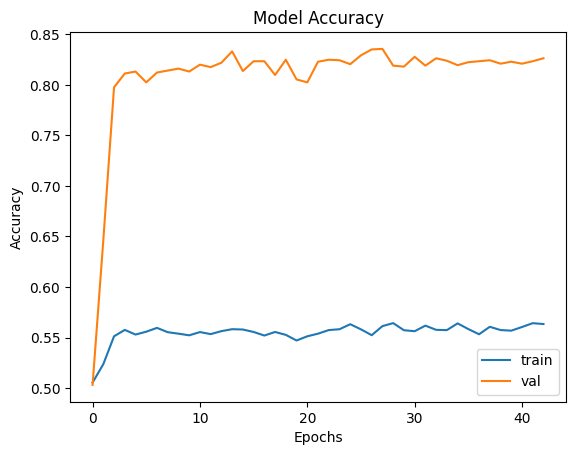

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 1 Testing

In [23]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 8s 105ms/step - loss: 0.4135 - accuracy: 0.8392


[0.4134889841079712, 0.8392466306686401]

In [24]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

2023-01-02 15:57:14.627172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 15:57:14.797420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 15:57:14.812434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 15:57:16.169488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 15:57:16.182775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 96ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

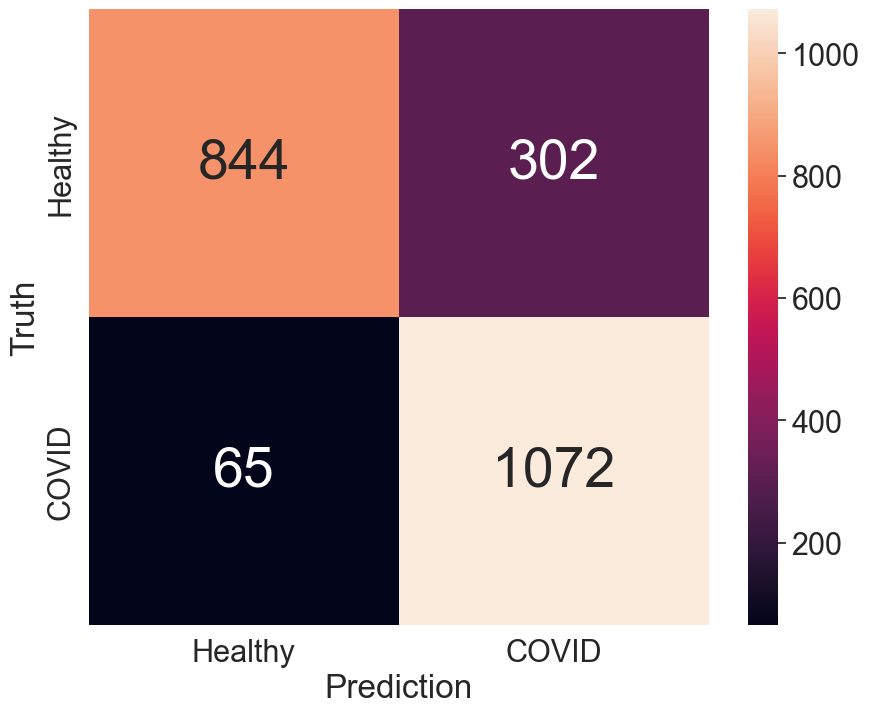

tf.Tensor(
[[ 844  302]
 [  65 1072]], shape=(2, 2), dtype=int32)


In [25]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [26]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

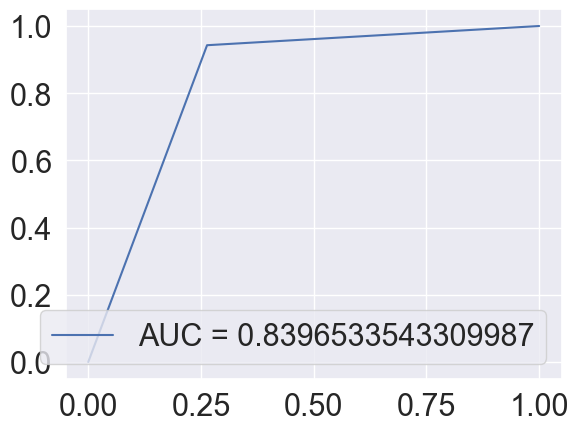

In [27]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import os
os._exit(00)

: 

: 